[Here](https://apmonitor.com/do/index.php/Main/TCLabA) is the link for this Lab. The purpose of this lab is to simulate the temperature with a SISO energy balance equation and compare it to predictions from a multi-layered neural network. 

In [ ]:
import numpy as np
from gekko import GEKKO
import matplotlib.pyplot as plt

def to_Kelvin(degCelsius):
    return degCelsius + 273.15

apm 10.32.114.116_gk_model10 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            2
   Variables    :            8
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:           1198
 Number of total equations: -         1198
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 **********************************************
 Dynamic Simulation with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains 

Text(0, 0.5, 'Temperature (C)')

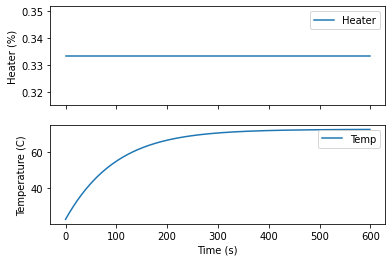

In [69]:
#lab printout says to simulate 1W step response for 10 minutes first... So I'll do that here. The rest of this follows the website.
#gekko modeling
m1 = GEKKO()

#simulation times (10 minutes)
total_min = 10
m1.time = np.arange(total_min*60)

#parameters/constants given in table
T0 = m1.Param(value=to_Kelvin(23.0))
Tinf = m1.Param(value=to_Kelvin(23.0))
Cp = m1.Param(value=500.0)
A = m1.Param(value=1.2e-3)
mass = m1.Param(value=.004)
U = m1.Param(10)
eps = m1.Const(.9)
sig = m1.Const(5.67e-8)

#input is Q, heater energy input (0-100%), just copying input trajectory from website
Qdes = np.ones(m1.time.shape)
Q = m1.Param(value=Qdes) # Percent Heater (0-100%). Heater goes from 0-3W

#state variables
T = m1.Var(value=T0)

#equations of motion, first order, nonlinear in this case
m1.Equation(mass*Cp*T.dt() == U*A*(Tinf - T) + eps*sig*A*(Tinf**4 - T**4) + Q)

#simulation settings
m1.options.IMODE = 4 #set simulation mode

m1.solve()

#plot results
fig,axs = plt.subplots(2,1, sharex=True)
axs[0].plot(m1.time, np.array(Q.VALUE)/3.0, label='Heater')
axs[0].legend()
axs[0].set_ylabel("Heater (%)")
axs[1].plot(m1.time, np.array(T.VALUE)-273.15, label='Temp')
axs[1].legend()
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Temperature (C)")

# SISO First-Principles Model

Small question... in the code on the website, he uses alpha=.01 as W / %heater. But then the table says the heater output can go 0-3W. If I want the heater 80% on, I should get a value of Q=.8\*3 = 2.4. But using his code, I get Q = alpha\*80 = .8 W. What's up there...? His code matches the actual data better.

In [76]:
#gekko modeling
m = GEKKO()

#simulation times (10 minutes)
total_min = 10
m.time = np.arange(total_min*60)

#parameters/constants given in table
T0 = m.Param(value=to_Kelvin(23.0))
Tinf = m.Param(value=to_Kelvin(23.0))
Cp = m.Param(value=500.0)
A = m.Param(value=1.2e-3)
mass = m.Param(value=.004)
U = m.Param(10)
eps = m.Const(.9)
sig = m.Const(5.67e-8)

#input is Q, heater energy input (0-100%), just copying input trajectory from website
Qdes = np.zeros(m.time.shape)
Qdes[10:200] = .8
Qdes[200:400] = .2
Qdes[400:] = .5
Q = m.Param(value=Qdes*3) # Percent Heater (0-100%). Heater goes from 0-3W

#state variables
T = m.Var(value=T0)

#equations of motion, first order, nonlinear in this case
m.Equation(mass*Cp*T.dt() == U*A*(Tinf - T) + eps*sig*A*(Tinf**4 - T**4) + Q)


In [77]:
#simulation settings
m.options.IMODE = 4 #set simulation mode

In [78]:
m.solve()

apm 10.32.114.116_gk_model14 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            2
   Variables    :            8
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:           1198
 Number of total equations: -         1198
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 **********************************************
 Dynamic Simulation with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains 

Text(0, 0.5, 'Temperature (C)')

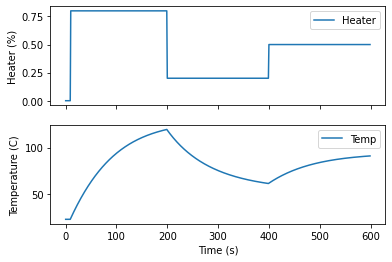

In [79]:
#plot results
fig,axs = plt.subplots(2,1, sharex=True)
axs[0].plot(m.time, np.array(Q.VALUE)/3.0, label='Heater')
axs[0].legend()
axs[0].set_ylabel("Heater (%)")
axs[1].plot(m.time, np.array(T.VALUE)-273.15, label='Temp')
axs[1].legend()
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Temperature (C)")

# Data Gather from TCLAB

In [56]:
import tclab
import time

# generate step test data on Arduino
filename = 'tclab_dyn_data1.csv'

# Connect to Arduino
a = tclab.TCLab()
fid = open(filename,'w')
fid.write('Time,H1,T1\n')
fid.close()

# run step test (10 min) 
# multiply Qdes by 100 b/c tclab needs 0-100.
for i in range(600):
    # set heater value
    a.Q1(Qdes[i]*100)
    print('Time: ' + str(i) + \
          ' H1: ' + str(Qdes[i]*100) + \
          ' T1: ' + str(a.T1))
    # wait 1 second
    time.sleep(1)
    # write results to file
    fid = open(filename,'a')
    fid.write(str(i)+','+str(Qdes[i]*100)+','+str(a.T1)+'\n')
    fid.close()
# close connection to Arduino
a.close()

TCLab version 0.4.9
Arduino Leonardo connected on port /dev/ttyACM0 at 115200 baud.
TCLab Firmware 2.0.1 Arduino Leonardo/Micro.
Time: 0 H1: 0.0 T1: 23.477
Time: 1 H1: 0.0 T1: 23.477
Time: 2 H1: 0.0 T1: 23.477
Time: 3 H1: 0.0 T1: 23.477
Time: 4 H1: 0.0 T1: 23.477
Time: 5 H1: 0.0 T1: 23.477
Time: 6 H1: 0.0 T1: 23.477
Time: 7 H1: 0.0 T1: 23.477
Time: 8 H1: 0.0 T1: 23.477
Time: 9 H1: 0.0 T1: 23.477
Time: 10 H1: 80.0 T1: 23.477
Time: 11 H1: 80.0 T1: 23.477
Time: 12 H1: 80.0 T1: 23.477
Time: 13 H1: 80.0 T1: 23.477
Time: 14 H1: 80.0 T1: 23.477
Time: 15 H1: 80.0 T1: 23.573
Time: 16 H1: 80.0 T1: 23.799
Time: 17 H1: 80.0 T1: 23.799
Time: 18 H1: 80.0 T1: 24.024
Time: 19 H1: 80.0 T1: 24.121
Time: 20 H1: 80.0 T1: 24.443
Time: 21 H1: 80.0 T1: 24.443
Time: 22 H1: 80.0 T1: 24.766
Time: 23 H1: 80.0 T1: 25.088
Time: 24 H1: 80.0 T1: 25.185
Time: 25 H1: 80.0 T1: 25.41
Time: 26 H1: 80.0 T1: 25.732
Time: 27 H1: 80.0 T1: 26.055
Time: 28 H1: 80.0 T1: 26.377
Time: 29 H1: 80.0 T1: 26.699
Time: 30 H1: 80.0 T1: 

IndexError: index 600 is out of bounds for axis 0 with size 600

Text(0, 0.5, 'Temperature (C)')

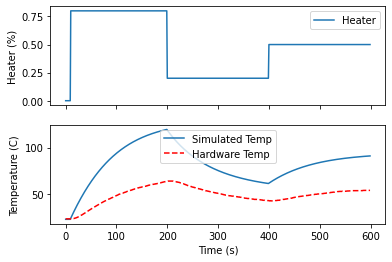

In [65]:
import pandas as pd
# read data file
data = pd.read_csv(filename)

# plot measurements
#plot results
fig,axs = plt.subplots(2,1, sharex=True)
axs[0].plot(m.time, np.array(Q.VALUE)/3.0, label='Heater')
axs[0].legend()
axs[0].set_ylabel("Heater (%)")
axs[1].plot(m.time, np.array(T.VALUE)-273.15, label='Simulated Temp')
axs[1].plot(data['Time'], data['T1'], 'r--', label='Hardware Temp')
axs[1].legend()
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Temperature (C)")


# Empirical Model

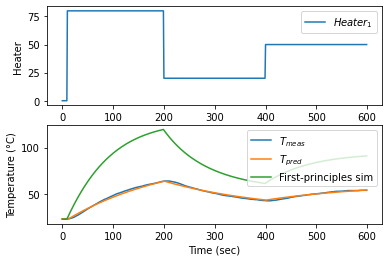

In [81]:
# load data and parse into columns
data = pd.read_csv(filename)
t = data['Time']
u = data['H1']
y = data['T1']

m3 = GEKKO()

# system identification
na = 2 # output coefficients
nb = 2 # input coefficients
yp,p,K = m3.sysid(t,u,y,na,nb,pred='meas')

plt.figure()
plt.subplot(2,1,1)
plt.plot(t,u,label=r'$Heater_1$')
plt.legend()
plt.ylabel('Heater')
plt.subplot(2,1,2)
plt.plot(t,y)
plt.plot(t,yp)
plt.plot(m.time, np.array(T.VALUE)-273.15, label='Temp')
plt.legend([r'$T_{meas}$',r'$T_{pred}$','First-principles sim'])
plt.ylabel('Temperature (°C)')
plt.xlabel('Time (sec)')
plt.show()